# CatBoost

In [2]:
# Import the libraries you'll need
import shap
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import optuna
from optuna.integration import OptunaSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

c:\WorkSpace\共同研究\matsushima\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# df = pd.read_excel("E:/Je respire/解析/1. 脳血流と問題カテゴリの関連.xlsx", sheet_name="ディアビアイ")
# df = pd.read_excel("/root/workspace/1.2 脳血流と問題カテゴリの関連 - 背外側追加.xlsx", sheet_name="ディアビアイ")
df = pd.read_excel("./1.2 脳血流と問題カテゴリの関連 - 背外側追加.xlsx", sheet_name="ディアビアイ")


In [10]:
df = df.drop(columns=['subject', 'question', 'q_category', #前半部分
                   'dataset_no', 'sheet_name']) # 後半部分

# df = df.iloc[24:246, :]  

In [11]:
# 脳血流のオキシヘモグロビンだけ使う場合
df = df.drop(columns=['CH1.1_std', 'CH2.1_std', 'CH3.1_std',
       'CH4.1_std', 'CH5.1_std', 'CH6.1_std', 'CH7.1_std', 'CH8.1_std',
       'CH9.1_std', 'CH10.1_std', 'CH11.1_std', 'CH12.1_std', 'CH13.1_std',
       'CH14.1_std', 'CH15.1_std', 'CH16.1_std', 'CH17.1_std', 'CH18.1_std',
       'CH19.1_std', 'CH20.1_std', 'CH21.1_std', 'CH22.1_std', 'CH1.2_std',
       'CH2.2_std', 'CH3.2_std', 'CH4.2_std', 'CH5.2_std', 'CH6.2_std',
       'CH7.2_std', 'CH8.2_std', 'CH9.2_std', 'CH10.2_std', 'CH11.2_std',
       'CH12.2_std', 'CH13.2_std', 'CH14.2_std', 'CH15.2_std', 'CH16.2_std',
       'CH17.2_std', 'CH18.2_std', 'CH19.2_std', 'CH20.2_std', 'CH21.2_std',
       'CH22.2_std' ]) # 後半部分

df = df.drop(columns=['right_pupil_std', 'CH1_std', 'CH2_std',
       'CH3_std', 'CH4_std', 'CH5_std', 'CH6_std', 'CH7_std', 'CH8_std',
       'CH9_std', 'CH10_std', 'CH11_std', 'CH12_std',
       'CH13_std', 'CH14_std', 'CH15_std', 'CH16_std', 'CH17_std',
       'CH18_std', 'CH19_std', 'CH20_std', 'CH21_std',
       'CH22_std']) # 主要な特徴量のみを残す場合


In [12]:
df['score'] = df['score'].replace(2, 1)

In [13]:
df.columns

Index(['score', 'left_pupil_std', 'right_haigai', 'hainai', 'left_haigai',
       'Sensor-E:SC/GSR_std', 'Sensor-G:BVP_std', '[G] BVP Amp._std',
       '[G] Heart Rate_std', '[G] HRV Amp._std',
       '[G] HRV-LF Power (0,04-0,16 Hz)_std',
       '[G] HRV-HF Power (0,16-0,4 Hz)_std', '[G] HRV-LF / HRV-HF _std'],
      dtype='object')

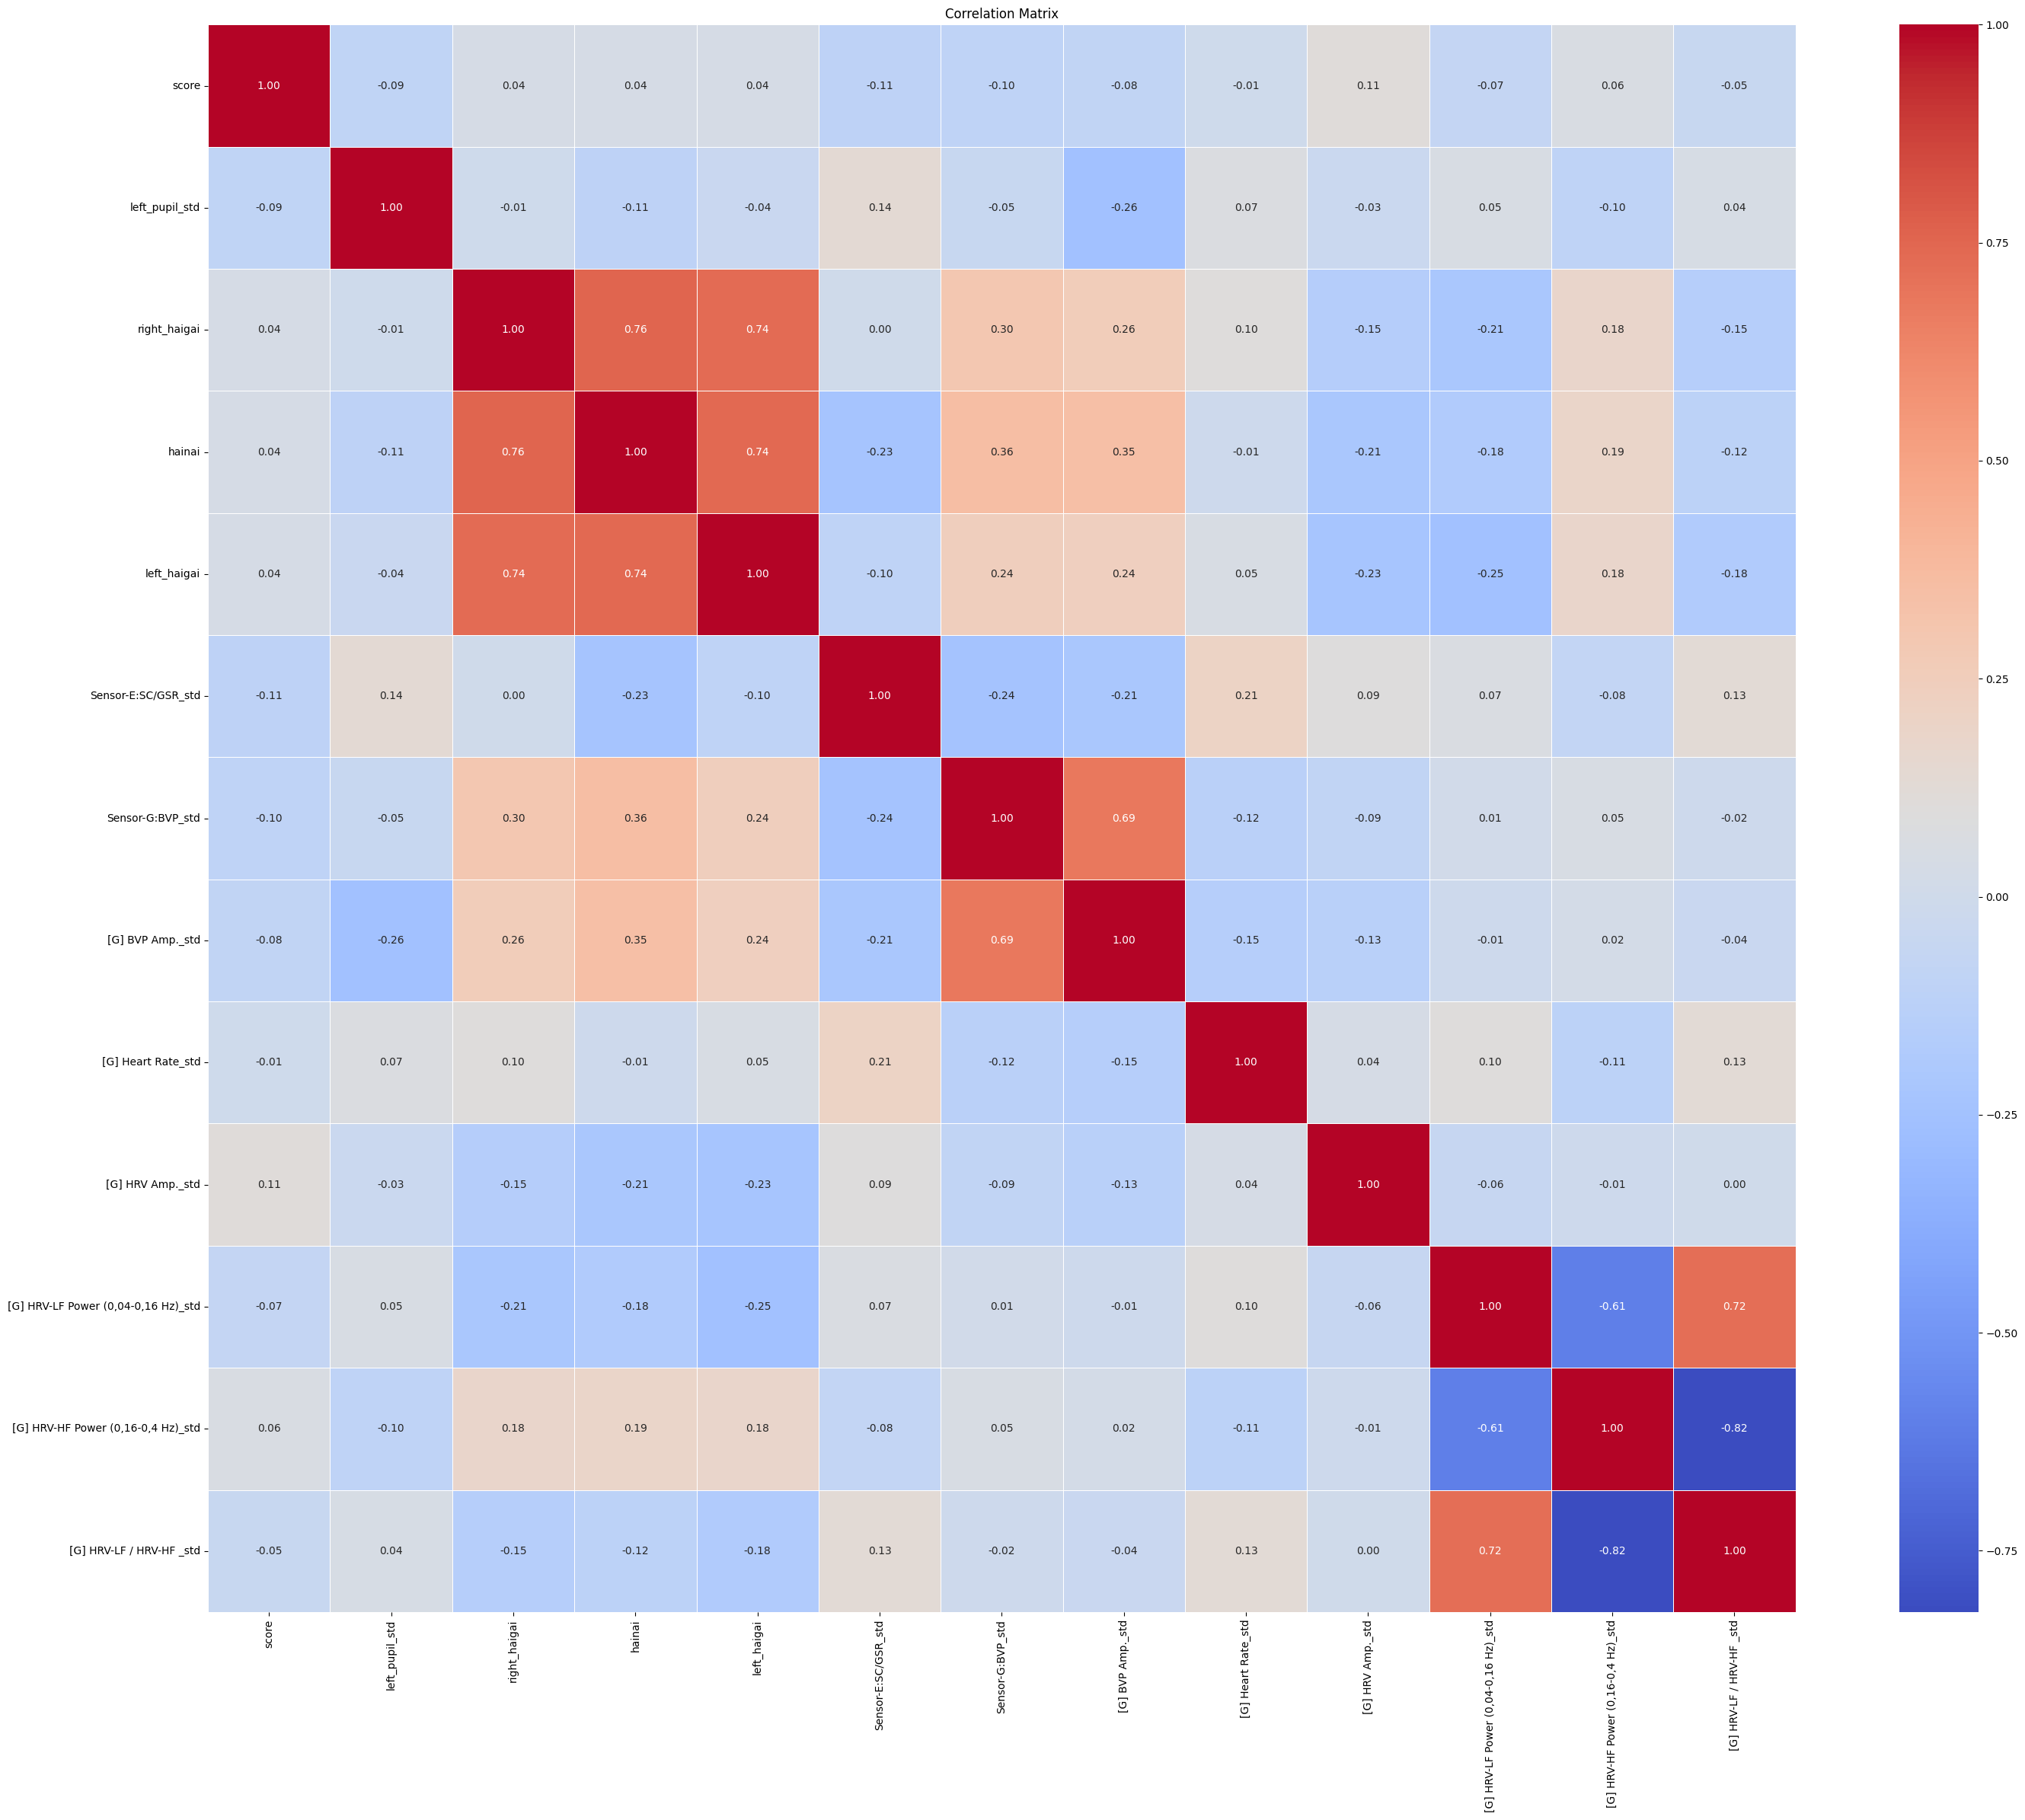

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 相関行列の計算
corr_matrix = df.corr(method='pearson')

# ヒートマップの描画
plt.figure(figsize=(30, 24))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


In [15]:
df.columns = [col.replace(':', '_')
                .replace('/', '_')
                .replace('[', '')
                .replace(']', '')
                .replace(' ', '_')
                .replace('.', '_')
                .replace(',', '_')
                .replace('(', '_')
                .replace(')', '_')
                for col in df.columns]

In [16]:
X = df.drop(columns=['score'])
y = df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = CatBoostClassifier(random_state=42, verbose=0)
model.fit(X_train, y_train)



In [17]:
# param_dist = {
#     'n_estimators': optuna.distributions.FloatDistribution(50, 500),
#     'max_depth': optuna.distributions.FloatDistribution(2, 50),
#     'min_samples_split': optuna.distributions.FloatDistribution(2, 5),
#     'min_samples_leaf': optuna.distributions.FloatDistribution(2, 10),
#     'max_features': ['sqrt', 'log2']
# }

# Define hyperparameter search space
param_dist = {
    "iterations": optuna.distributions.IntDistribution(200, 1000),
    "depth": optuna.distributions.IntDistribution(3, 10),
    "learning_rate": optuna.distributions.FloatDistribution(1e-3, 0.3, log=True),
    "l2_leaf_reg": optuna.distributions.FloatDistribution(1, 10),
    "bagging_temperature": optuna.distributions.FloatDistribution(0, 1),
    "border_count": optuna.distributions.IntDistribution(32, 255),
}

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

optuna_search = OptunaSearchCV(
    model,
    param_dist,
    cv=cv, # 交差検証の設定
    n_trials=50, # トライアル回数
    scoring='accuracy', # 評価指標
    n_jobs=-1, # 計算するコアの数
    verbose=1
)

C:\Users\thisi\AppData\Local\Temp\ipykernel_42968\2398993884.py:21: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(


In [18]:
optuna_search.fit(X_train, y_train) # モデルの学習
y_pred = optuna_search.predict(X_test) # テストデータに対する予測

[I 2025-10-30 18:23:56,237] A new study created in memory with name: no-name-a98fc240-e321-412a-a6ad-eb034dc479b1
[I 2025-10-30 18:23:58,615] Trial 2 finished with value: 0.6614583333333334 and parameters: {'iterations': 343, 'depth': 3, 'learning_rate': 0.004069854743576955, 'l2_leaf_reg': 6.452959077993292, 'bagging_temperature': 0.530411562982189, 'border_count': 233}. Best is trial 2 with value: 0.6614583333333334.
[I 2025-10-30 18:23:58,887] Trial 10 finished with value: 0.6510416666666667 and parameters: {'iterations': 347, 'depth': 4, 'learning_rate': 0.0011647165410367472, 'l2_leaf_reg': 2.029058375690682, 'bagging_temperature': 0.48125291995285524, 'border_count': 176}. Best is trial 2 with value: 0.6614583333333334.
[I 2025-10-30 18:23:59,811] Trial 1 finished with value: 0.65625 and parameters: {'iterations': 598, 'depth': 4, 'learning_rate': 0.0011630254575350338, 'l2_leaf_reg': 8.714123965756166, 'bagging_temperature': 0.7922820708279548, 'border_count': 37}. Best is trial

In [19]:
print("Best parameters: ", optuna_search.best_params_) # 最良のパラメータの表示
print("Test set accuracy: ", accuracy_score(y_test, y_pred)) # テストデータに対する予測精度の表示
print(accuracy_score(y_train, optuna_search.predict(X_train))) # 学習データに対する予測精度の表示

Best parameters:  {'iterations': 634, 'depth': 3, 'learning_rate': 0.001011857062406053, 'l2_leaf_reg': 4.765081794524504, 'bagging_temperature': 0.7902397104328729, 'border_count': 65}
Test set accuracy:  0.6666666666666666
0.671875


In [20]:
explainer = shap.TreeExplainer(model=optuna_search.best_estimator_)
shap_values = explainer.shap_values(X)
explanation = explainer(X)

In [21]:
print(explainer)
print(shap_values)
print(explanation)

[[ 6.50875946e-03  3.28128737e-02 -1.79585601e-05 ... -1.02011488e-02
   1.85853820e-02  2.43782218e-02]
 [ 3.57015219e-03  3.42536623e-02  7.36732561e-03 ... -1.03470274e-02
   1.99761168e-02  2.37685535e-02]
 [-3.57861528e-02  3.32239561e-02  8.70810945e-03 ... -1.01123477e-02
   1.84342252e-02  2.17408026e-02]
 ...
 [-7.96360767e-03 -8.55224566e-03 -4.07928748e-03 ... -3.23249669e-02
  -5.31125036e-04 -2.17143151e-02]
 [-9.46818550e-03 -4.69632211e-03 -3.58123898e-03 ...  3.36428831e-02
   2.81684810e-03 -7.95123717e-03]
 [-1.06025743e-02 -2.84265526e-04 -2.77959803e-03 ...  3.45292628e-02
   1.92046073e-03 -1.47674264e-02]]
.values =
array([[ 6.50875946e-03,  3.28128737e-02, -1.79585601e-05, ...,
        -1.02011488e-02,  1.85853820e-02,  2.43782218e-02],
       [ 3.57015219e-03,  3.42536623e-02,  7.36732561e-03, ...,
        -1.03470274e-02,  1.99761168e-02,  2.37685535e-02],
       [-3.57861528e-02,  3.32239561e-02,  8.70810945e-03, ...,
        -1.01123477e-02,  1.84342252e-02, 

In [22]:
shap_values.shape

(240, 12)

In [23]:
shap_values


array([[ 6.50875946e-03,  3.28128737e-02, -1.79585601e-05, ...,
        -1.02011488e-02,  1.85853820e-02,  2.43782218e-02],
       [ 3.57015219e-03,  3.42536623e-02,  7.36732561e-03, ...,
        -1.03470274e-02,  1.99761168e-02,  2.37685535e-02],
       [-3.57861528e-02,  3.32239561e-02,  8.70810945e-03, ...,
        -1.01123477e-02,  1.84342252e-02,  2.17408026e-02],
       ...,
       [-7.96360767e-03, -8.55224566e-03, -4.07928748e-03, ...,
        -3.23249669e-02, -5.31125036e-04, -2.17143151e-02],
       [-9.46818550e-03, -4.69632211e-03, -3.58123898e-03, ...,
         3.36428831e-02,  2.81684810e-03, -7.95123717e-03],
       [-1.06025743e-02, -2.84265526e-04, -2.77959803e-03, ...,
         3.45292628e-02,  1.92046073e-03, -1.47674264e-02]],
      shape=(240, 12))

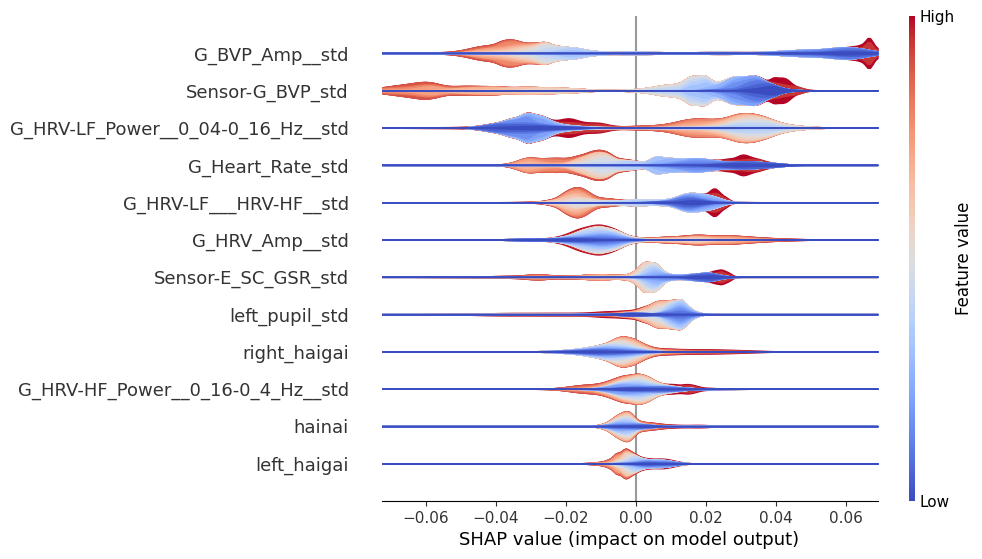

In [24]:
feat_names = list(X.columns)
shap.plots.violin(shap_values, features=X, feature_names=feat_names, plot_type="layered_violin")

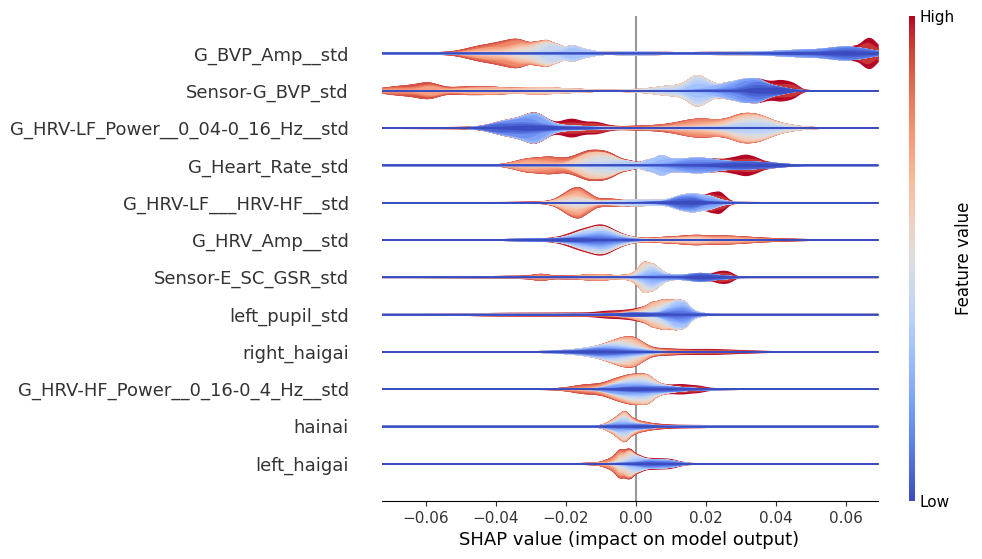

In [25]:
feat_names = list(X.columns)
shap.plots.violin(shap_values, features=X, feature_names=feat_names, plot_type="layered_violin")

In [26]:
print(X.columns)

Index(['left_pupil_std', 'right_haigai', 'hainai', 'left_haigai',
       'Sensor-E_SC_GSR_std', 'Sensor-G_BVP_std', 'G_BVP_Amp__std',
       'G_Heart_Rate_std', 'G_HRV_Amp__std',
       'G_HRV-LF_Power__0_04-0_16_Hz__std', 'G_HRV-HF_Power__0_16-0_4_Hz__std',
       'G_HRV-LF___HRV-HF__std'],
      dtype='object')


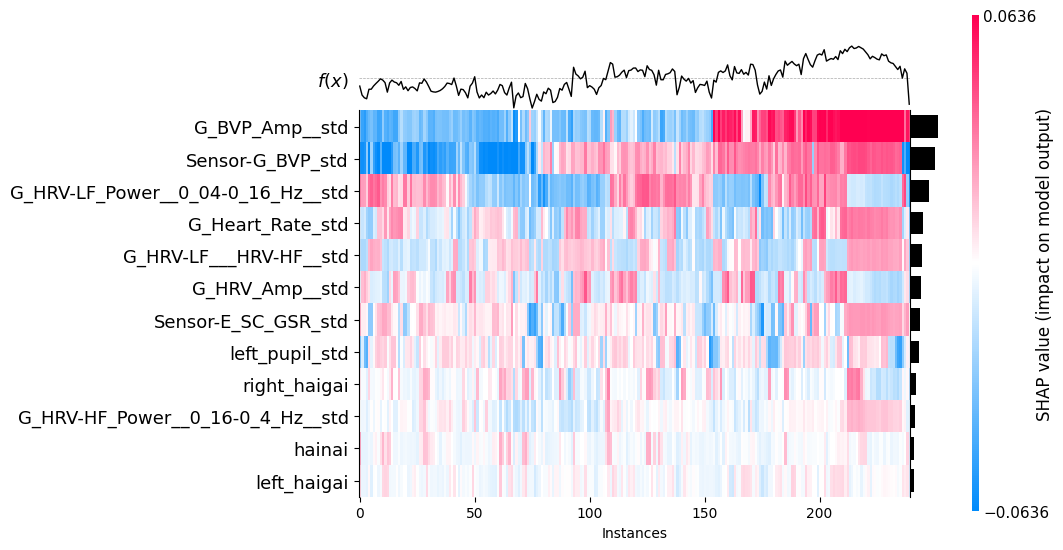

<Axes: xlabel='Instances'>

In [27]:
shap.plots.heatmap(explanation, max_display=12)

Index(['left_pupil_std', 'right_haigai', 'hainai', 'left_haigai',
       'Sensor-E_SC_GSR_std', 'Sensor-G_BVP_std', 'G_BVP_Amp__std',
       'G_Heart_Rate_std', 'G_HRV_Amp__std',
       'G_HRV-LF_Power__0_04-0_16_Hz__std', 'G_HRV-HF_Power__0_16-0_4_Hz__std',
       'G_HRV-LF___HRV-HF__std'],
      dtype='object')


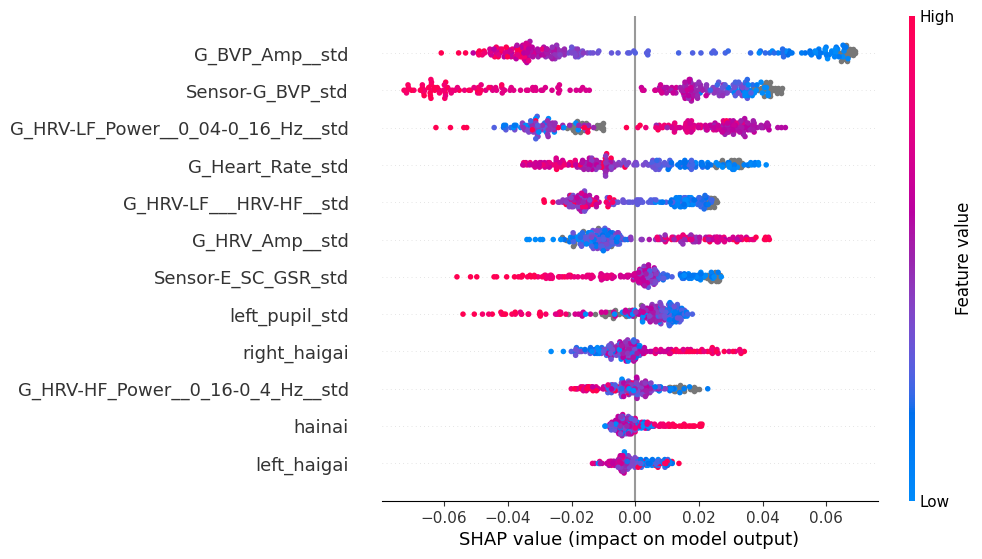

In [28]:
print(X.columns)
shap.plots.beeswarm(explanation, max_display=20)

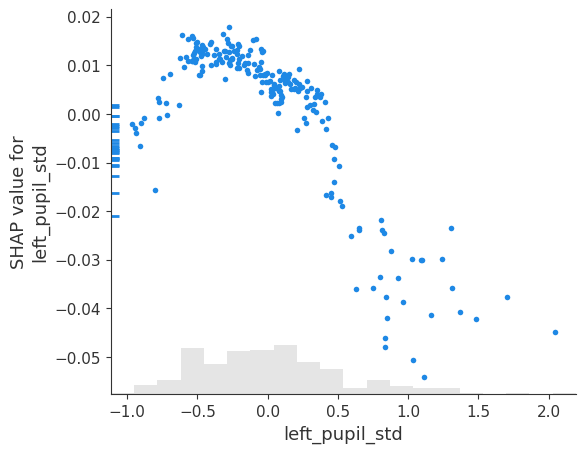

In [40]:
# shap.plots.scatter(explanation[:, "left_pupil_std"], color=explanation[:, "right_pupil_std"])
shap.plots.scatter(explanation[:,0])

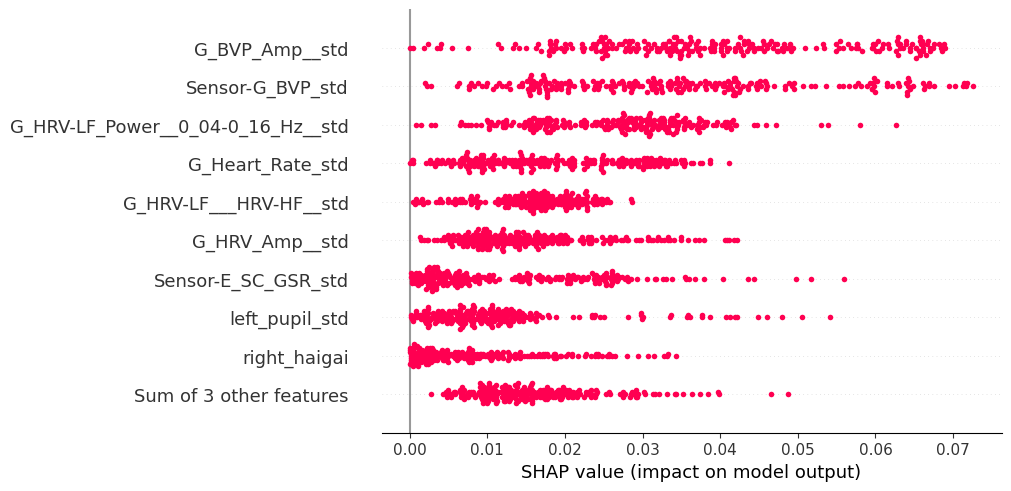

In [30]:
shap.plots.beeswarm(explanation.abs, color="shap_red")

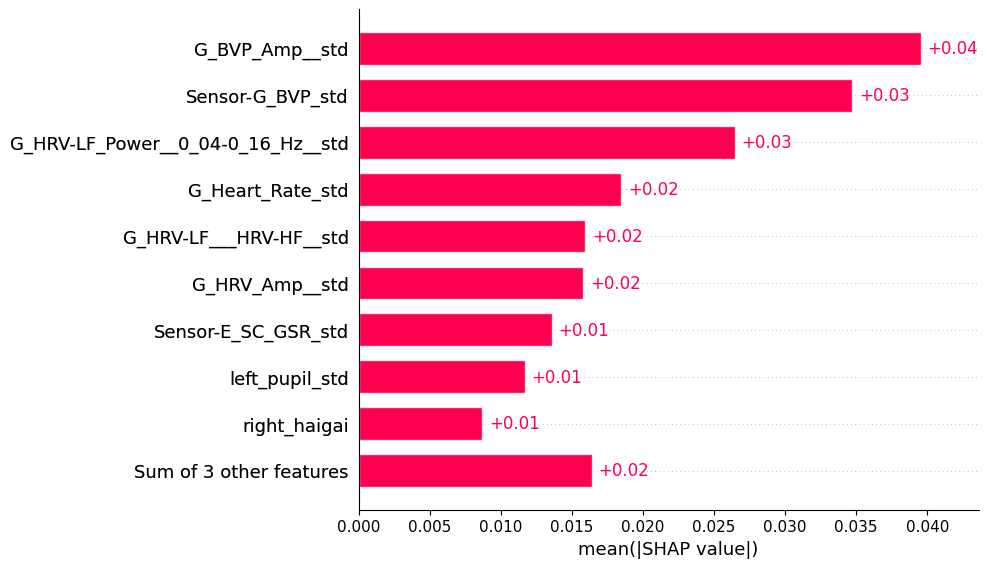

In [31]:
shap.plots.bar(explanation.abs.mean(0))

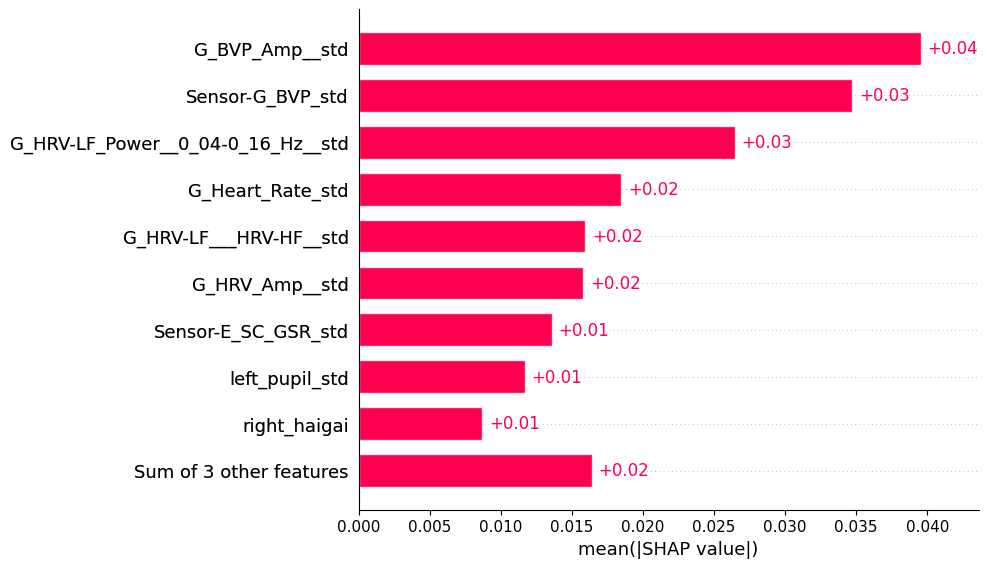

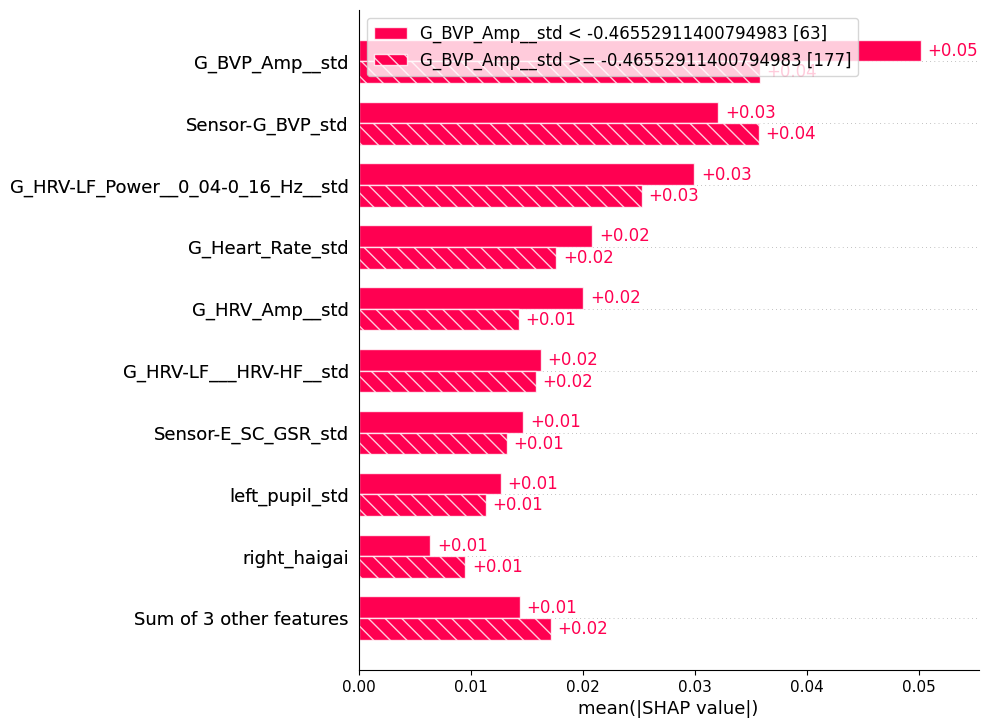

In [32]:
shap.plots.bar(explanation)
shap.plots.bar(explanation.cohorts(2).abs.mean(0))

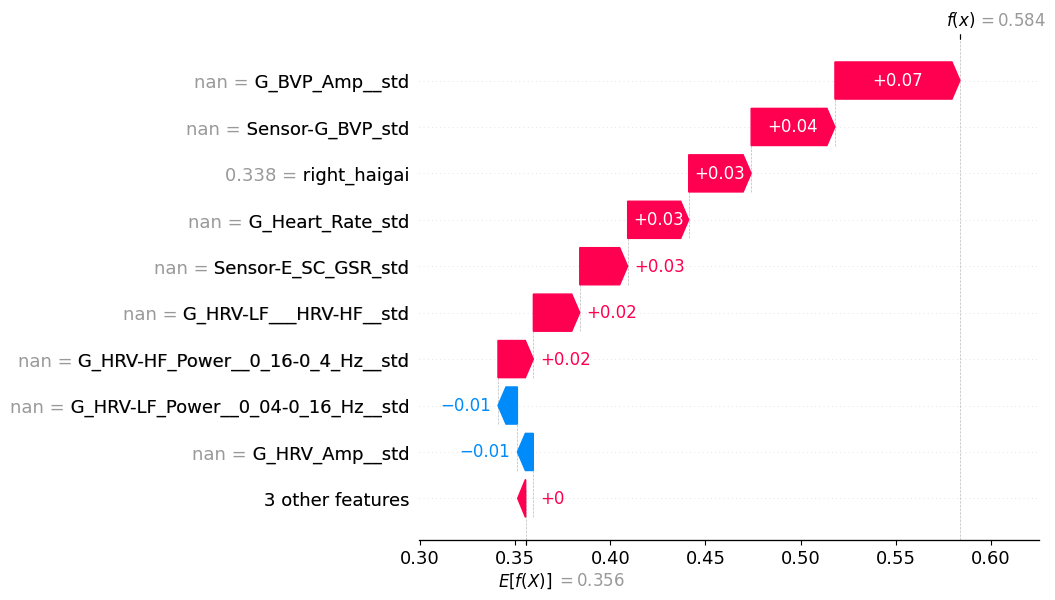

In [34]:
shap.plots.waterfall(explanation[0])

In [35]:
import json
import yaml
import pandas as pd
import numpy as np
from joblib import dump

from datetime import datetime

# 現在時刻を取得して、フォーマット
now = datetime.now()
timestamp = now.strftime('%Y%m%d_%H%M%S')



# 4. 保存処理
dump(model, f'C:/WorkSpace/共同研究/松島さん/Je respire ノーパソ/結果保存/model{timestamp}.joblib')  # モデル
with open(f'C:/WorkSpace/共同研究/松島さん/Je respire ノーパソ/結果保存/params{timestamp}.yaml', 'w') as f:
    yaml.dump(optuna_search.best_params_, f)     # ハイパーパラメータ
with open(f'C:/WorkSpace/共同研究/松島さん/Je respire ノーパソ/結果保存/metrics{timestamp}.json', 'w') as f:
    json.dump(accuracy_score(y_test, y_pred), f)    # 精度
pd.DataFrame(shap_values[1]).to_csv(f'C:/WorkSpace/共同研究/松島さん/Je respire ノーパソ/結果保存/shap_values{timestamp}.csv', index=False)  # SHAP値（クラス1）

# 5. オプション：SHAP explainerも保存
dump(explainer, f'C:/WorkSpace/共同研究/松島さん/Je respire ノーパソ/結果保存/shap_explainer{timestamp}.joblib')


['C:/WorkSpace/共同研究/松島さん/Je respire ノーパソ/結果保存/shap_explainer20251030_182555.joblib']